<a href="https://colab.research.google.com/github/jiayuangu762943/2022-spring-dov-level-ie/blob/main/3_training_and_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3. Training and Testing**
Please start early! Section 3.6 Training may take one to two hours to run.

## 3.0 Setup GDrive and Git

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Make sure your token is stored in a txt file at the location below.
# This way there is no risk that you will push it to your repo
# Never share your token with anyone, it is basically your github password!
with open('/content/gdrive/MyDrive/ece5545/token.txt') as f:
    token = f.readline().strip()
# Use another file to store your github username
with open('/content/gdrive/MyDrive/ece5545/git_username.txt') as f:
    handle = f.readline().strip()

In [ ]:
# Clone your github repo
YOUR_TOKEN = token
YOUR_HANDLE = handle
BRANCH = "main"

%mkdir /content/gdrive/MyDrive/ece5545
%cd /content/gdrive/MyDrive/ece5545
!git clone https://{YOUR_TOKEN}@github.com/ML-HW-SYS/a2-{YOUR_HANDLE}.git
%cd /content/gdrive/MyDrive/ece5545/a2-{YOUR_HANDLE}
!git checkout {BRANCH}
!git pull
%cd /content/gdrive/MyDrive/ece5545

PROJECT_ROOT = f"/content/gdrive/MyDrive/ece5545/a2-{YOUR_HANDLE}"

mkdir: cannot create directory ‘/content/gdrive/MyDrive/ece5545’: File exists
/content/gdrive/MyDrive/ece5545
fatal: destination path 'a2-jiayuangu762943' already exists and is not an empty directory.
/content/gdrive/MyDrive/ece5545/a2-jiayuangu762943
Already on 'main'
Your branch is up to date with 'origin/main'.
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 7.42 KiB | 223.00 KiB/s, done.
From https://github.com/ML-HW-SYS/a2-jiayuangu762943
   7a26637..eb3697e  main       -> origin/main
Updating 7a26637..eb3697e
Fast-forward
 2_size_estimator_and_profiler.ipynb | 447 ++++++++++++++++++++++++++++++++++++++++++++++++--------
 1 file changed, 384 insertions(+), 63 deletions(-)
/content/gdrive/MyDrive/ece5545


In [ ]:
# This extension reloads all imports before running each cell
%load_ext autoreload
%autoreload 2

### GPU

Ensure you are running the GPU runtime type:
1.   Click "Runtime" on top banner
2.   Select "Change runtime type"
3.   Under "Hardware accelarator" select "GPU" and save



### Import code dependencies

In [ ]:
import os
import sys

# Adding assignment 2 to the system path
# -- make sure this matches your git directory
sys.path.insert(0, PROJECT_ROOT)

# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import copy

# Import constants to use constants defined for training
from src.constants import *
# Import data_proc to use data processing functions
import src.data_proc as data_proc

random_seed = 0
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

Model folders are created, 
PyTorch models will be saved in /content/gdrive/MyDrive/ece5545/models/torch_models, 
ONNX models will be saved in /content/gdrive/MyDrive/ece5545/models/onnx_models, 
TensorFlow Saved Models will be saved in /content/gdrive/MyDrive/ece5545/models/tf_models, 
TensorFlow Lite models will be saved in /content/gdrive/MyDrive/ece5545/models/tflite_models, 
TensorFlow Lite Micro models will be saved in /content/gdrive/MyDrive/ece5545/models/micro_models.


## 3.1 Download and Preprocess Data

### Create audio processor
This step is similar to what was done in part 2, so the files should already be downloaded in your Google Drive.

In [ ]:
# Create audio_processor
audio_processor = data_proc.AudioProcessor()

>> Downloading speech_commands_v0.02.tar.gz 100.0%


### Select device: cuda or cpu

In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} to run the training scrpit.')

Using cuda to run the training scrpit.


## 3.2 Data Loader

In [ ]:
# Define train, test, and validation set
train_set = audio_processor.data_index['training']
test_set = audio_processor.data_index['testing']
valid_set = audio_processor.data_index['validation']

# Define data loaders
from src.loaders import make_data_loaders
data_loaders = make_data_loaders(audio_processor, device)
train_loader = data_loaders['training']
test_loader = data_loaders['testing']
valid_loader = data_loaders['validation']

Train size: 10556 Val size: 1333 Test size: 1368


## 3.3 Define the Model

In [ ]:
from src.networks import TinyConv
# Create a full precision (float32) TinyConv model
model_fp32 = TinyConv(
    model_settings=audio_processor.model_settings,
    n_input=1,
    n_output=audio_processor.num_labels
)
model_fp32

TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

## 3.4 Training

In [ ]:
from src.train_val_test_utils import train, test

### Adjust parameters
*   You can change *n_epoch* to use a different number training steps/epochs

In [ ]:
num_batches = len(train_loader)
n_epoch = 50
print(f'# batches: {num_batches} \n# epochs: {n_epoch} \n# total training steps: {num_batches * n_epoch}')

# batches: 106 
# epochs: 50 
# total training steps: 5300


### Create optimizer for training
 Explore more at:
[TORCH. OPTIM](https://pytorch.org/docs/stable/optim.html?highlight=torch%20optim%20lr_scheduler)

In [ ]:
from src.train_val_test_utils import create_optimizer

# Create optimizer
optimizer_fp32 = create_optimizer(model=model_fp32, learning_rate=0.001)
print(optimizer_fp32.state_dict())

{'state': {}, 'param_groups': [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3]}]}


### Train the model
TensorBoard will allow you to visualize your results. The second code block, the training, will take a while to run.

In [ ]:
pbar_update = 1 / (len(train_loader) + len(test_loader) + len(valid_loader))

def run_training(model, data_loaders, n_epoch, optimizer,
                 save_interval=1, resume=True, checkpoint_path=None):
    test_loader = data_loaders['testing']
    with tqdm(total=n_epoch) as pbar:

        completed_epoch = 1
        if resume:
            try:
                #continue training with previous model if one exists
                checkpoint = torch.load(checkpoint_path)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                completed_epoch = checkpoint["epoch"] + 1
                model.eval()
                pbar.update(completed_epoch)
            except:
                pass

        last_valacc = 0
        for epoch in range(completed_epoch, n_epoch + 1):
            train_iters = len(data_loaders['training'])

            train(model, data_loaders, optimizer,
                      epoch, device)

            valacc = test(valid_loader, model, device, epoch=epoch,
                          loader_type='Valid', verbose=True)
            #checkpoint the model every epoch
            if epoch % save_interval == 0 and valacc > last_valacc:
                last_valacc = valacc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()
                }, checkpoint_path)

            # Update epoch pbar
            pbar.update(1)

        testacc = test(test_loader, model, device,
                     epoch=None, loader_type='Test')
        print(f'Test Acc = {round(testacc,2)}%')


# This is where your checkpoint file will be saved
checkpoint_path = os.path.join(TORCH_DIR, "fp32_checkpoint.pt")

model_fp32.to(device)
run_training(
    model=model_fp32, data_loaders=data_loaders,
    n_epoch=n_epoch, optimizer=optimizer_fp32,
    resume=True, checkpoint_path=checkpoint_path
)

  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-13-0f09e9a81e5e>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Val Acc Epoch 1 = 83.57%, Train loss = 1.11

Valid epoch: 1	Accuracy: 1110/1333 (83.27%)

Val Acc Epoch 2 = 87.17%, Train loss = 0.549

Valid epoch: 2	Accuracy: 1146/1333 (85.97%)

Val Acc Epoch 3 = 86.57%, Train loss = 0.491

Valid epoch: 3	Accuracy: 1148/1333 (86.12%)

Val Acc Epoch 4 = 88.22%, Train loss = 0.464

Valid epoch: 4	Accuracy: 1168/1333 (87.62%)

Val Acc Epoch 5 = 88.22%, Train loss = 0.447

Valid epoch: 5	Accuracy: 1166/1333 (87.47%)

Val Acc Epoch 6 = 88.3%, Train loss = 0.431

Valid epoch: 6	Accuracy: 1166/1333 (87.47%)

Val Acc Epoch 7 = 88.37%, Train loss = 0.427

Valid epoch: 7	Accuracy: 1181/1333 (88.60%)

Val Acc Epoch 8 = 87.77%, Train loss = 0.424

Valid epoch: 8	Accuracy: 1182/1333 (88.67%)

Val Acc Epoch 9 = 87.62%, Train loss = 0.414

Valid epoch: 9	Accuracy: 1180/1333 (88.52%)

Val Acc Epoch 10 = 89.57%, Train loss = 0.405

Valid epoch: 10	Accuracy: 1197/1333 (89.80%)

Val Acc Epoch 11 = 89.35%, Train loss = 0.396

Valid epoch: 11	Accuracy: 1194/1333 (89.57%

## 3.5 Testing

### Calculating accuracy


Train size: 10556 Val size: 1333 Test size: 1368


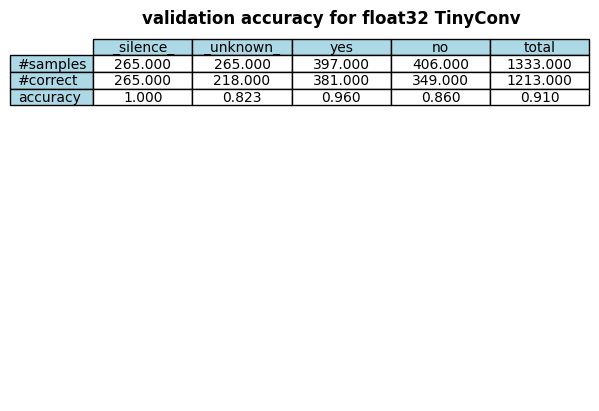

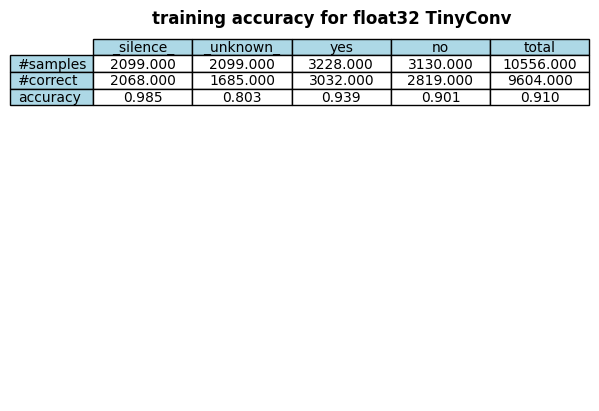

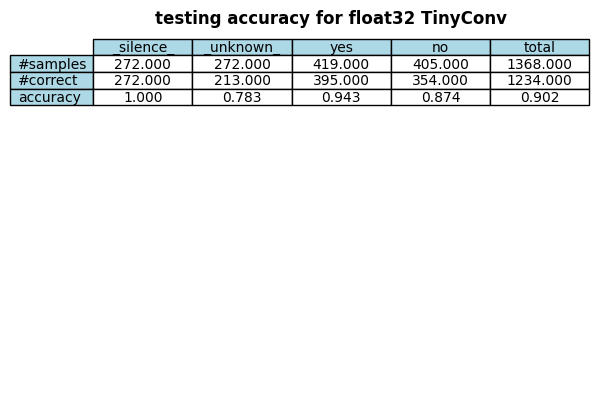

In [ ]:
from src.train_val_test_utils import plot_acc

test_time_data_loaders = make_data_loaders(
    audio_processor, device,
    test_batch_size=1, valid_batch_size=1,
    num_workers=0
)

plot_acc(
    test_time_data_loaders['validation'], model_fp32, audio_processor, device,
    "validation", 'float32 TinyConv', "float")
plot_acc(
    test_time_data_loaders['training'], model_fp32, audio_processor, device,
    "training", 'float32 TinyConv', "float")
acc = plot_acc(
    test_time_data_loaders['testing'], model_fp32, audio_processor, device,
    'testing', 'float32 TinyConv', "float")

## 3.6 Save the Trained Model

In [ ]:
def choose_name(model_name):
    name = f"{model_name}_" + "{index}"
    i = 0
    while os.path.isfile(name.format(index=i)):
        i += 1
    name = name.format(index = i)
    print(f"The model's will be stored as: \n {name}")
    return name

def save_model(model, path):
    torch.save(model.state_dict(), path)

In [ ]:
# Choose a path
# You can also define your own path
model_name = f"tinyconv_float32_init_seed{torch.initial_seed()}_{acc * 100:.2f}%"
file_name = choose_name(model_name)
torch_path = os.path.join(TORCH_DIR, f'{file_name}.pt')
torch_path

The model's will be stored as: 
 tinyconv_float32_init_seed0_90.20%_0


'/content/gdrive/MyDrive/ece5545/models/torch_models/tinyconv_float32_init_seed0_90.20%_0.pt'

In [ ]:
# Save the trained pytorch model to torch_path
save_model(model_fp32, torch_path)
'Saved!'

'Saved!'

In [ ]:
'You can now find your model in %s under the folder icon to the left.' % torch_path

'You can now find your model in /content/gdrive/MyDrive/ece5545/models/torch_models/tinyconv_float32_init_seed0_90.20%_0.pt under the folder icon to the left.'